In [1]:
import transformers
from tqdm.notebook import tqdm  as tqdm
import numpy as np
import math
import torch
import torch.nn as nn
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup

zh_tokenizer = transformers.AutoTokenizer.from_pretrained("hfl/chinese-xlnet-base")
en_tokenizer = transformers.AutoTokenizer.from_pretrained("xlnet-base-cased")

In [2]:
zh_tokenizer.convert_tokens_to_ids("<pad>"), en_tokenizer.convert_tokens_to_ids("<pad>")

(5, 5)

In [3]:
class EntityDataset:
    def __init__(self, src, trg):
        self.src = src
        self.trg = trg
        self.MAX_LEN = 128
    
    def __len__(self):
        return len(self.src)
    
    def __getitem__(self, item):
        src = self.src[item]
        trg = self.trg[item]

        mask = [1] * len(src)

        src_padding_len = self.MAX_LEN - len(src)
        trg_padding_len = self.MAX_LEN - len(trg)

        src = src + ([5] * src_padding_len) 
        trg = trg + ([5] * trg_padding_len)

        return {
            "src": torch.tensor(src, dtype=torch.long),
            "trg": torch.tensor(trg, dtype=torch.long),
        }

def get_data_loader(en_path, zh_path):
    src_ids = []
    trg_ids = []

    with open(en_path) as src:
        data = src.readlines()
        for ids in tqdm(data):
            ids_list = ids.split(" ")[:-1]
            ids_list = [int(ids_list[i]) for i in range(len(ids_list))]
            src_ids.append(ids_list)

    with open(zh_path) as trg:
        data = trg.readlines()
        for ids in tqdm(data):
            ids_list = ids.split(" ")[:-1]
            ids_list = [int(ids_list[i]) for i in range(len(ids_list))]
            trg_ids.append(ids_list)
    return src_ids, trg_ids

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, max_len):
        super().__init__()
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1)
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) # 1000^(2i/dim_model)
        
        # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)
        
    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        return self.pos_encoding[:token_embedding.size(0), :]

In [5]:
class Transformer(nn.Module):
    def __init__(
        self,
        embedding_size,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        forward_expansion,
        dropout,
        max_len,
        device,
    ):
        super(Transformer, self).__init__()
        self.src_word_embedding = nn.Embedding(src_vocab_size, embedding_size)
        self.src_position_embedding = PositionalEncoding(embedding_size, max_len)
        self.trg_word_embedding = nn.Embedding(trg_vocab_size, embedding_size)
        self.trg_position_embedding = PositionalEncoding(embedding_size, max_len)

        self.device = device
        self.transformer = nn.Transformer(
            embedding_size,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
            forward_expansion,
            dropout,
        )
        self.fc_out = nn.Linear(embedding_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.src_pad_idx = src_pad_idx

    def make_src_mask(self, src):
        src_mask = src.transpose(0, 1) == self.src_pad_idx

        # (N, src_len)
        return src_mask.to(self.device)

    def forward(self, src, trg):
        src_seq_length, N = src.shape
        trg_seq_length, N = trg.shape

        word_src = self.src_word_embedding(src)
        word_trg = self.trg_word_embedding(trg)

        embed_src = self.dropout((word_src + self.src_position_embedding(src)))
        embed_trg = self.dropout((word_trg + self.trg_position_embedding(trg)))

        src_padding_mask = self.make_src_mask(src)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_length).to(self.device)

        out = self.transformer(
            embed_src,
            embed_trg,
            src_key_padding_mask=src_padding_mask,
            tgt_mask=trg_mask,
        )
        out = self.fc_out(out)
        return out

In [6]:
train_en, train_zh = get_data_loader("./data/train.en", "./data/train.zh")
valid_en, valid_zh = get_data_loader("./data/valid.en", "./data/valid.zh")
test_en, test_zh = get_data_loader("./data/test.en", "./data/test.zh")

  0%|          | 0/279916 [00:00<?, ?it/s]

  0%|          | 0/279916 [00:00<?, ?it/s]

  0%|          | 0/15512 [00:00<?, ?it/s]

  0%|          | 0/15512 [00:00<?, ?it/s]

  0%|          | 0/15626 [00:00<?, ?it/s]

  0%|          | 0/15626 [00:00<?, ?it/s]

In [7]:
Batch_size = 128

train_dataset = EntityDataset(train_en, train_zh)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=Batch_size)

valid_dataset = EntityDataset(valid_en, valid_zh)
valid_data_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=Batch_size)

test_dataset = EntityDataset(test_en, test_zh)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=Batch_size)

In [18]:
from transformer_model import Transformer as Mytransformer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

src_vocab_size = len(en_tokenizer.vocab)
trg_vocab_size = len(zh_tokenizer.vocab)
embedding_size = 512
num_heads = 4
num_encoder_layers = 3
num_decoder_layers = 3
dropout = 0.10
max_len = 128
forward_expansion = 4
src_pad_idx = en_tokenizer.convert_tokens_to_ids("<pad>")
trg_pad_idx = zh_tokenizer.convert_tokens_to_ids("<pad>")


model = Mytransformer(src_vocab_size, 
                      trg_vocab_size, 
                      src_pad_idx, 
                      trg_pad_idx,
                      embed_size=embedding_size, 
                      num_layers=num_encoder_layers,
                      forward_expansion=4,
                      heads= num_heads,
                      dropout=dropout,
                      max_length=max_len,
                      device=device).to(device)

In [19]:
learning_rate = 5e-4
batch_size = 128
num_epochs = 25

num_train_steps = int(
    len(train_dataset) / batch_size * num_epochs
)

optimizer = AdamW(model.parameters(), lr=learning_rate)

trg_pad_idx = zh_tokenizer.convert_tokens_to_ids("<pad>")
criterion = nn.CrossEntropyLoss(ignore_index = trg_pad_idx, label_smoothing=0.1)

scheduler = get_cosine_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=200, 
    num_training_steps=num_train_steps)

In [20]:
best_loss = np.inf

for epoch in range(num_epochs):
    print("Epoch {}/{}:".format(epoch+1, num_epochs))

    model.train()
    train_losses = []
    final_loss = 0
    for batch_idx, batch in enumerate(tqdm(valid_data_loader)):
        inp_data = batch["src"].to(device)
        target = batch["trg"].to(device)
        output = model(inp_data, target[:, :-1])
        output = output.reshape(-1, output.shape[2])
        target = target[:, 1:].reshape(-1)
        
        optimizer.zero_grad()
        loss = criterion(output, target)
        loss.backward()        
        optimizer.step()
        scheduler.step()

        final_loss += loss.item()
    train_loss = final_loss / len(valid_data_loader)
    train_losses.append(train_loss)
    
    current_lr = optimizer.state_dict()['param_groups'][0]['lr']

    model.eval()
    valid_losses = []
    final_loss = 0
    for batch_idx, batch in enumerate(valid_data_loader):
        inp_data = batch["src"].to(device)
        target = batch["trg"].to(device)
        output = model(inp_data, target[:, :-1])
        output = output.reshape(-1, output.shape[2])
        target = target[:, 1:].reshape(-1)
        
        loss = criterion(output, target)
        final_loss += loss.item()
    valid_loss = final_loss / len(valid_data_loader)
    valid_losses.append(valid_loss)
    
    print("train loss: {} | valid_loss: {} | learning rate: {}".format(train_loss, valid_loss, current_lr))

Epoch 1/25:


  0%|          | 0/122 [00:00<?, ?it/s]

train loss: 7.447718940797399 | valid_loss: 6.35254774328138 | learning rate: 0.000305
目标句子: 但进展不应被称作胜利。
预测句子: ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
********************
Epoch 2/25:


  0%|          | 0/122 [00:00<?, ?it/s]

train loss: 6.289741617734315 | valid_loss: 6.086721228771522 | learning rate: 0.0004999991950216841
目标句子: 但进展不应被称作胜利。
预测句子: ['事实上,这在中国的。']
********************
Epoch 3/25:


  0%|          | 0/122 [00:00<?, ?it/s]

train loss: 6.045190584464152 | valid_loss: 5.7638504817837575 | learning rate: 0.0004999885424457946
目标句子: 但进展不应被称作胜利。
预测句子: ['我们是,这将是。']
********************
Epoch 4/25:


  0%|          | 0/122 [00:00<?, ?it/s]

train loss: 5.744608535141241 | valid_loss: 5.381872865020251 | learning rate: 0.0004999655131083889
目标句子: 但进展不应被称作胜利。
预测句子: ['但这是什么样的。']
********************
Epoch 5/25:


  0%|          | 0/122 [00:00<?, ?it/s]

train loss: 5.460981853672715 | valid_loss: 5.101390209354338 | learning rate: 0.0004999301081496337
目标句子: 但进展不应被称作胜利。
预测句子: ['但这并不是不应该是。']
********************
Epoch 6/25:


  0%|          | 0/122 [00:00<?, ?it/s]

train loss: 5.198743198738724 | valid_loss: 4.859196766478116 | learning rate: 0.0004998823293224042
目标句子: 但进展不应被称作胜利。
预测句子: ['但这并不是没有人的。']
********************
Epoch 7/25:


  0%|          | 0/122 [00:00<?, ?it/s]

train loss: 4.9700159479360115 | valid_loss: 4.582607839928299 | learning rate: 0.0004998221789921976
目标句子: 但进展不应被称作胜利。
预测句子: ['但这并不是不仅仅是正确的。']
********************
Epoch 8/25:


  0%|          | 0/122 [00:00<?, ?it/s]

train loss: 4.771344648032892 | valid_loss: 4.397481380916033 | learning rate: 0.0004997496601370153
目标句子: 但进展不应被称作胜利。
预测句子: ['但这并不仅仅是正确的。']
********************
Epoch 9/25:


  0%|          | 0/122 [00:00<?, ?it/s]

train loss: 4.600592333762372 | valid_loss: 4.217675582307284 | learning rate: 0.0004996647763472163
目标句子: 但进展不应被称作胜利。
预测句子: ['但这并不仅仅是正确的。']
********************
Epoch 10/25:


  0%|          | 0/122 [00:00<?, ?it/s]

train loss: 4.432357268255265 | valid_loss: 4.013471869171643 | learning rate: 0.0004995675318253389
目标句子: 但进展不应被称作胜利。
预测句子: ['但这并不是是个问题。']
********************
Epoch 11/25:


  0%|          | 0/122 [00:00<?, ?it/s]

train loss: 4.270497691435892 | valid_loss: 3.8159068754461947 | learning rate: 0.0004994579313858927
目标句子: 但进展不应被称作胜利。
预测句子: ['但这并非如此。']
********************
Epoch 12/25:


  0%|          | 0/122 [00:00<?, ?it/s]

train loss: 4.120963610586573 | valid_loss: 3.648605932954882 | learning rate: 0.0004993359804551204
目标句子: 但进展不应被称作胜利。
预测句子: ['但这并不是是个关键因素。']
********************
Epoch 13/25:


  0%|          | 0/122 [00:00<?, ?it/s]

train loss: 3.982201553759028 | valid_loss: 3.5276199168846256 | learning rate: 0.0004992016850707291
目标句子: 但进展不应被称作胜利。
预测句子: ['但这并不是是个进步。']
********************
Epoch 14/25:


  0%|          | 0/122 [00:00<?, ?it/s]

train loss: 3.862503116248084 | valid_loss: 3.323356758375637 | learning rate: 0.0004990550518815912
目标句子: 但进展不应被称作胜利。
预测句子: ['但这并不是是重要的进展。']
********************
Epoch 15/25:


  0%|          | 0/122 [00:00<?, ?it/s]

train loss: 3.7249075203645425 | valid_loss: 3.1593173761836817 | learning rate: 0.0004988960881474157
目标句子: 但进展不应被称作胜利。
预测句子: ['但这并非是进步的进展。']
********************
Epoch 16/25:


  0%|          | 0/122 [00:00<?, ?it/s]

train loss: 3.5959056273835603 | valid_loss: 3.011433841752224 | learning rate: 0.0004987248017383881
目标句子: 但进展不应被称作胜利。
预测句子: ['但这并非是进步的。']
********************
Epoch 17/25:


  0%|          | 0/122 [00:00<?, ?it/s]

train loss: 3.4798829496883954 | valid_loss: 2.8796197263920895 | learning rate: 0.000498541201134781
目标句子: 但进展不应被称作胜利。
预测句子: ['但这并不是是进步的进展。']
********************
Epoch 18/25:


  0%|          | 0/122 [00:00<?, ?it/s]

train loss: 3.375208170687566 | valid_loss: 2.8242852521724386 | learning rate: 0.0004983452954265348
目标句子: 但进展不应被称作胜利。
预测句子: ['但进展却不是进展的进展。']
********************
Epoch 19/25:


  0%|          | 0/122 [00:00<?, ?it/s]

train loss: 3.2648927794128166 | valid_loss: 2.6532741736193173 | learning rate: 0.0004981370943128068
目标句子: 但进展不应被称作胜利。
预测句子: ['但进展不仅仅是进步的进展。']
********************
Epoch 20/25:


  0%|          | 0/122 [00:00<?, ?it/s]

train loss: 3.1640650962219863 | valid_loss: 2.5372038288194627 | learning rate: 0.0004979166081014914
目标句子: 但进展不应被称作胜利。
预测句子: ['但进展不是进展的进展,而是积极进展。']
********************
Epoch 21/25:


  0%|          | 0/122 [00:00<?, ?it/s]

train loss: 3.06135082049448 | valid_loss: 2.402822041609248 | learning rate: 0.0004976838477087103
目标句子: 但进展不应被称作胜利。
预测句子: ['但进展不仅仅是胜利。']
********************
Epoch 22/25:


  0%|          | 0/122 [00:00<?, ?it/s]

train loss: 2.965046148808276 | valid_loss: 2.2814131330271237 | learning rate: 0.0004974388246582707
目标句子: 但进展不应被称作胜利。
预测句子: ['但进展不仅仅是胜利。']
********************
Epoch 23/25:


  0%|          | 0/122 [00:00<?, ?it/s]

train loss: 2.8750524721184716 | valid_loss: 2.180235998552354 | learning rate: 0.0004971815510810962
目标句子: 但进展不应被称作胜利。
预测句子: ['但进展却不错过了。']
********************
Epoch 24/25:


  0%|          | 0/122 [00:00<?, ?it/s]

train loss: 2.7915907595001284 | valid_loss: 2.1108825216527847 | learning rate: 0.0004969120397146255
目标句子: 但进展不应被称作胜利。
预测句子: ['但进展不仅仅是胜利。']
********************
Epoch 25/25:


  0%|          | 0/122 [00:00<?, ?it/s]

train loss: 2.7063615458910584 | valid_loss: 2.006202404616309 | learning rate: 0.0004966303039021817
目标句子: 但进展不应被称作胜利。
预测句子: ['但进展却不仅仅是胜利。']
********************


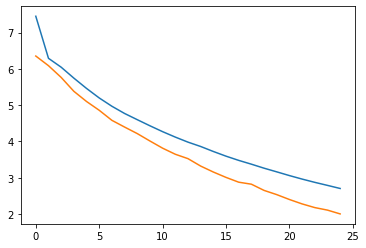

In [93]:
import matplotlib.pyplot as plt

epochs = [i for i in range(25)]

plt.plot(epochs, train_losses)
plt.plot(epochs, valid_losses)
plt.show()

In [70]:
zh_sentence = "2012年10月,IMF大大赞扬了新兴经济体的恢复力。"
infer_sentence = [3, 25, 665, 1311, 19, 18, 8903, 6570, 5714, 7690, 12, 17, 12, 88, 23, 8307, 2612, 9, 12, 4]
infer_dataset = EntityDataset([infer_sentence], [infer_sentence])
infer_data_loader = torch.utils.data.DataLoader(infer_dataset, batch_size=1)
batch = next(iter(infer_data_loader))
inp_data = batch["src"].to(device)
outputs = [zh_tokenizer.convert_tokens_to_ids("<cls>")]


for i in range(128):
    trg_tensor = torch.LongTensor(outputs).unsqueeze(1).to(device)
    trg_tensor = trg_tensor.reshape(1,-1)
    with torch.no_grad():
        output = model(inp_data, trg_tensor)

    output = output.permute(1,0,2)
    best_guess = output.argmax(2)[-1, :].item()
    outputs.append(best_guess)

    if best_guess == zh_tokenizer.convert_tokens_to_ids("<sep>"):
        break

    translated_sentence = zh_tokenizer.decode(outputs).split(" ")[1:-1]
print("目标句子: {}".format(zh_sentence))
print("预测句子: {}".format(translated_sentence[0]))
print('*' * 20)

目标句子: 2012年10月,IMF大大赞扬了新兴经济体的恢复力。
预测句子: 2012年10月,IMF预测"新兴经济体"一词。
********************
